## Code To Generate Datasets using the Generated Images!

In [1]:
# Imports 
import os
from rembg import remove
import io
import random
import yaml
import os
from PIL import Image, ImageTk
import tkinter as tk
from helper_functions_image_creation import *
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

In [2]:
import os

# Model
%env CUDA_VISIBLE_DEVICES=3,2
#%env PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:32

# HF Cache
os.environ["HF_HOME"] = "../.cache"
!echo $HF_HOME
!huggingface-cli whoami

env: CUDA_VISIBLE_DEVICES=3,2
../.cache


TorgeSchwark
orgs:  Basket-AEye


### Cut out Background of generated images and crop them

In [21]:
def remove_background_and_crop_cli(input_dir='../huggingface/ai_shelf/sd/second',
                                   output_dir='../huggingface/ai_shelf/sd/second_without_background',
                                   batch_size=10):
    os.makedirs(output_dir, exist_ok=True)
    images_to_process = []

    for subfolder in os.listdir(input_dir):
        subfolder_path = os.path.join(input_dir, subfolder)
        if os.path.isdir(subfolder_path):
            output_subfolder = os.path.join(output_dir, subfolder)
            os.makedirs(output_subfolder, exist_ok=True)

            for file_name in os.listdir(subfolder_path):
                if file_name.endswith('.png'):
                    input_path = os.path.join(subfolder_path, file_name)
                    output_file_name = file_name.replace('.png', '_no_background.png')
                    output_path = os.path.join(output_subfolder, output_file_name)
                    images_to_process.append((input_path, output_path))

    total = len(images_to_process)
    i = 0

    while i < total:
        batch = images_to_process[i:i+batch_size]
        processed_batch = []

        # Bearbeite und speichere temporär bearbeitete Bilder
        for input_path, output_path in batch:
            try:
                with open(input_path, 'rb') as f:
                    input_data = f.read()
                output_data = remove(input_data)
                output_image = Image.open(io.BytesIO(output_data)).convert("RGBA")
                bbox = output_image.getbbox()
                cropped_image = output_image.crop(bbox)
                processed_batch.append((cropped_image, output_path))
            except Exception as e:
                print(f"⚠️ Fehler bei {input_path}: {e}")

        # Zeige Vorschau als Grid
        clear_output(wait=True)
        fig, axs = plt.subplots(1, len(processed_batch), figsize=(len(processed_batch)*2, 2.5))
        if len(processed_batch) == 1:
            axs = [axs]
        for ax, (img, _) in zip(axs, processed_batch):
            ax.imshow(img)
            ax.axis('off')
        plt.show()

        # Nutzerentscheidung für Batch
        decision = input(f"\nBatch {i+1}–{i+len(processed_batch)}: [j] alle speichern, [n] alle verwerfen, [e] einzeln durchgehen? ").strip().lower()
        if decision == 'j':
            for img, output_path in processed_batch:
                img.save(output_path)
                print(f"✔️ Gespeichert: {output_path}")
        elif decision == 'e':
            for img, output_path in processed_batch:
                clear_output(wait=True)
                display(img.resize((300, 300)))
                single_decision = input("✅ Speichern [j] oder ❌ Verwerfen [n]? [j/n]: ").strip().lower()
                if single_decision == 'j' or single_decision == '':
                    img.save(output_path)
                    print(f"✔️ Gespeichert: {output_path}")
                else:
                    print("⛔️ Verworfen.")
        else:
            print("⛔️ Batch verworfen.")

        i += batch_size

    print("\n✅ Alle Bilder durchlaufen.")


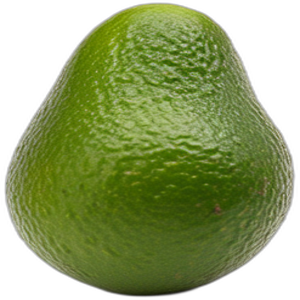

✔️ Gespeichert: ../huggingface/ai_shelf/sd/second_without_background/avocado/avocado_00320__no_background.png

✅ Alle Bilder durchlaufen.


In [22]:
remove_background_and_crop_cli()

In [3]:
def load_images(object_folders, background_folder, ratio=[60, 30, 10]):
    """
    Load and split images into training, validation, and test sets based on the given ratio.
    Returns object_dict, background_dict, and category_to_id (mapping category name -> int ID).
    """
    objects_dict = {}
    backgrounds = []

    # Load object images and scale per category
    for subfolder in os.listdir(object_folders):
        subfolder_path = os.path.join(object_folders, subfolder)

        if os.path.isdir(subfolder_path):
            object_files = [f for f in os.listdir(subfolder_path) if f.endswith('.png')]

            # Try to load scale.txt
            scale_path = os.path.join(subfolder_path, "scale.txt")
            if os.path.exists(scale_path):
                with open(scale_path, "r") as f:
                    try:
                        scale_value = float(f.read().strip())
                    except ValueError:
                        print(f"Warning: Could not parse scale.txt in {subfolder}, defaulting to 1.0")
                        scale_value = 1.0
            else:
                print(f"Warning: No scale.txt found in {subfolder}, defaulting to 1.0")
                scale_value = 1.0

            objects_dict[subfolder] = {
                "files": object_files,
                "scale": scale_value
            }

    # Load background images
    for f in os.listdir(background_folder):
        if f.endswith('.png'):
            backgrounds.append(os.path.join(background_folder, f))

    # Split background images based on the ratio
    train_bg = backgrounds[:int(len(backgrounds) * ratio[0] / 100)]
    val_bg = backgrounds[int(len(backgrounds) * ratio[0] / 100):int(len(backgrounds) * (ratio[0] + ratio[1]) / 100)]
    test_bg = backgrounds[int(len(backgrounds) * (ratio[0] + ratio[1]) / 100):]

    # Split object images into dictionaries for each set
    def split_objects(objects_dict):
        split = {"train": {}, "val": {}, "test": {}}
        for category, data in objects_dict.items():
            files = data["files"]
            scale = data["scale"]

            train_size = int(len(files) * ratio[0] / 100)
            val_size = int(len(files) * ratio[1] / 100)

            split["train"][category] = {"files": files[:train_size], "scale": scale}
            split["val"][category] = {"files": files[train_size:train_size + val_size], "scale": scale}
            split["test"][category] = {"files": files[train_size + val_size:], "scale": scale}
        return split

    object_dict = split_objects(objects_dict)

    # Create category-to-ID mapping
    category_to_id = {category: idx for idx, category in enumerate(sorted(objects_dict.keys()))}

    print("done loading and splitting images")
    backgrounds_dict = {"train": train_bg, "val": val_bg, "test": test_bg}
    
    return object_dict, backgrounds_dict, category_to_id



def generate_images_and_labels(objects_dict, backgrounds, objects_folder, output_folder, output_labels, category_to_id, model, count=1000):
    """
    Generate images using a specific set of objects and backgrounds.
    objects_dict has format: {category: {"files": [...], "scale": float}}
    """
    os.makedirs(output_folder, exist_ok=True)
    os.makedirs(output_labels, exist_ok=True)

    i = 0
    while i < count:
        # Select a random background
        background_image = Image.open(random.choice(backgrounds)).convert("RGBA")
        
        num_objects = random.randint(1, 15)
        selected_objects = []
        object_counts = {key: 0 for key in objects_dict.keys()}

        for _ in range(num_objects):
            category = random.choice(list(objects_dict.keys()))
            file = random.choice(objects_dict[category]["files"])
            scale = objects_dict[category]["scale"]

            path = os.path.join(objects_folder, category, file)
            image = Image.open(path).convert("RGBA")
            image.info["custom_scale"] = scale  # Übergib scale an späteren Code
            selected_objects.append((image, category))

        # Place the objects on the background
        result, yolo_labels = place_objects_on_background(background_image, selected_objects, object_counts, category_to_id, model)

        if result is False and yolo_labels is False:
            print(f"[{i+1}/{count}] Kein Objekt konnte platziert werden, wiederhole...")
            continue  # Wiederhole Iteration ohne i zu erhöhen

        # Save the generated image
        image_filename = f'generated_image_{i+1}.png'
        result.save(os.path.join(output_folder, image_filename))

        # Save YOLO labels
        label_filename = image_filename.replace(".png", ".txt")
        label_path = os.path.join(output_labels, label_filename)
        with open(label_path, "w") as f:
            for label in yolo_labels:
                f.write(label + "\n")

        print(f"[{i+1}/{count}] Bild gespeichert: {image_filename}")
        i += 1  # Nur erhöhen, wenn erfolgreich

        
def create_yaml_for_generated(output_folders, category_to_id, output_dir):
    """
    Create a dataset.yaml file for the generated dataset.

    Args:
        output_folders (dict): Dictionary with keys 'train', 'val', 'test', and their corresponding folder paths.
        category_to_id (dict): Mapping from category name to unique integer ID.
        output_dir (str): Directory where the dataset.yaml file should be saved.
    """
    os.makedirs(output_dir, exist_ok=True)

    # Build the YAML data
    yaml_data = {
        "train": os.path.relpath(output_folders["train"], output_dir),
        "val": os.path.relpath(output_folders["val"], output_dir),
        "nc": len(category_to_id),
        "names": {v: k for k, v in sorted(category_to_id.items(), key=lambda x: x[1])}
    }

    # Write YAML to file
    yaml_path = os.path.join(output_dir, "dataset.yaml")
    with open(yaml_path, 'w') as yaml_file:
        yaml.dump(yaml_data, yaml_file, sort_keys=False)

    print(f"dataset.yaml created at: {yaml_path}")


In [4]:
import sys
sys.path.append("/data22/stu236894/GitRepos/TinyML-MT/code_imagegeneration/models/external/cyclegan/models")

In [ ]:
# Main folder containing the objects
objects_folders = '../huggingface/ai_shelf/sd/second_without_background'
background_folder = '../huggingface/ai_shelf/sd/backgrounds'

objects_dicts, backgrounds_dict, category_to_id= load_images(objects_folders, background_folder)
output_folders = {"train": "../huggingface/ai_shelf/created/images/train", "val": "../huggingface/ai_shelf/created/images/val", "test": "../huggingface/ai_shelf/created/images/test"}
output_folder_lable = {"train": "../huggingface/ai_shelf/created/labels/train", "val": "../huggingface/ai_shelf/created/labels/val", "test":"../huggingface/ai_shelf/created/labels/test"}

generate_images_and_labels(objects_dicts["train"], backgrounds_dict["train"], objects_folders, output_folders["train"],output_folder_lable["train"],  category_to_id, count=20)
generate_images_and_labels(objects_dicts["val"], backgrounds_dict["val"], objects_folders, output_folders["val"], output_folder_lable["val"], category_to_id, count=20)
generate_images_and_labels(objects_dicts["test"], backgrounds_dict["test"], objects_folders, output_folders["test"],output_folder_lable["test"], category_to_id, count=20)
create_yaml_for_generated(output_folders, category_to_id, "./generated")


done loading and splitting images
1 161 143
2 179 163
1 161 272
2 193 290
1 148 252
2 148 252
Object tomato sauce could not be placed after 8 attempts.
[1/20] Bild gespeichert: generated_image_1.png
1 94 334
2 94 334
1 144 214
2 168 230
1 169 156
2 191 180
1 170 216
2 170 216
[2/20] Bild gespeichert: generated_image_2.png
1 90 186
2 90 186
1 106 99
2 118 111
1 132 197
2 150 209
1 228 230
2 270 272
Object cucumber could not be placed after 8 attempts.
1 131 186
2 171 212
Object banana could not be placed after 8 attempts.
1 105 195
2 139 211
1 228 95
2 242 131
[3/20] Bild gespeichert: generated_image_3.png
1 73 214
2 73 214
1 133 185
2 133 185
1 119 127
2 137 145
1 110 102
2 116 108
1 89 184
2 127 200
1 102 215
2 144 233
Object cucumber could not be placed after 8 attempts.
1 101 175
2 105 177
1 96 180
2 122 192
[4/20] Bild gespeichert: generated_image_4.png
1 99 318
2 99 318
1 207 267
2 207 267
1 172 274
2 206 294
Object banana could not be placed after 8 attempts.
[5/20] Bild gespeich